In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
import cv2
import os
import sys

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
# the location of R (used for the mclust clustering)
# os.environ['R_HOME'] = 'D:\Program Files\R\R-4.0.3'
os.environ['R_HOME'] = '/home/miniconda3/envs/3.7/lib/R/'
# os.environ['R_USER'] = 'D:\ProgramData\Anaconda3\Lib\site-packages\rpy2'
os.environ['R_USER'] = '/home/miniconda3/envs/3.7/lib/python3.7/site-packages/rpy2'

In [5]:
#Read in gene expression and spatial location
adata1=sc.read("../dataset/DLPFC/151673/sample_data.h5ad")
#Read in hitology image
img=cv2.imread("../dataset/DLPFC/151673/histology.tif")

In [6]:
section_id = '151673'

In [7]:
input_dir = os.path.join('../dataset/DLPFC', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [8]:
adata.obs = adata.obs.rename(columns={'array_row': 'x_array'})
adata.obs = adata.obs.rename(columns={'array_col': 'y_array'})

In [10]:
adata.obs["x_pixel"]=adata1.obs["x4"]
adata.obs["y_pixel"]=adata1.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

cv2.imwrite('../dataset/DLPFC/151673/map.jpg', img_new)

True

In [12]:
#将adata存成raw文件(.h5ad)用于识别SVG
adata.write("../dataset/DLPFC/151673/processed_data.h5ad")


In [13]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [14]:
# read the annotation
Ann_df = pd.read_csv(os.path.join('../dataset/DLPFC', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

## Constructing the spatial network

In [17]:
import sys
import os

In [18]:
import utils
import Train_STAGATE

Instructions for updating:
non-resource variables are not supported in the long term


------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.


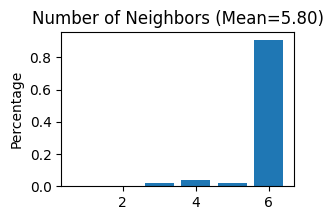

In [19]:
utils.Cal_Spatial_Net(adata, rad_cutoff=150)
utils.Stats_Spatial_Net(adata)

In [21]:
adata = Train_STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (3639, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-07-14 15:58:05.445009: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-07-14 15:58:05.453408: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2900000000 Hz
2024-07-14 15:58:05.456019: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5641f443c690 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-14 15:58:05.456056: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-07-14 15:58:05.457271: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-14 15:58:05.479882: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-14 15:58:05.480205: I tensorflow/stream_executor/cuda/cuda_diagnostics

In [22]:
print(adata.shape)
print(adata)

(3639, 33538)
AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'


In [23]:
'''
在单细胞RNA测序数据上执行降维、计算邻居关系并进行聚类。最终adata对象将包含降维后的数据、UMAP坐标和聚类结果
'''
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata = utils.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [25]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.60


In [33]:
mclust_array = adata.obs["mclust"].to_numpy(dtype=np.int64)

## Indentify SVGs

In [35]:
#Calculate adjacent matrix
s=1
b=49
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
np.savetxt('../dataset/DLPFC/151673/adj.csv', adj, delimiter=',')

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  33.30687202862215 174.55510595352243 46.84205750749746
Var of x,y,z =  5606737.526317932 4468793.817921193 5606737.526317932


In [36]:
#Expression data preprocessing
adj=np.loadtxt('../dataset/DLPFC/151673/adj.csv', delimiter=',')
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

**5.2 Set hyper-parameters
p: Percentage of total expression contributed by neighborhoods.
l: Parameter to control p.**

In [37]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 153.8820492650696]
Run 2: l [0.01, 500.005], p [0.0, 28.015447343094223]
Run 3: l [0.01, 250.0075], p [0.0, 4.240330523308446]
Run 4: l [0.01, 125.00874999999999], p [0.0, 0.5157276735032843]
Run 5: l [62.509375, 125.00874999999999], p [0.028496868560644373, 0.5157276735032843]
Run 6: l [93.7590625, 125.00874999999999], p [0.18753135107474428, 0.5157276735032843]
Run 7: l [109.38390625, 125.00874999999999], p [0.32801349789332424, 0.5157276735032843]
Run 8: l [117.196328125, 125.00874999999999], p [0.4156469508032292, 0.5157276735032843]
Run 9: l [121.1025390625, 125.00874999999999], p [0.4640926787304587, 0.5157276735032843]
Run 10: l [123.05564453125, 125.00874999999999], p [0.48950676051756026, 0.5157276735032843]
recommended l =  124.032197265625


n_clusters: Number of spatial domains wanted.
res: Resolution in the initial Louvain's Clustering methods. If the number of clusters is known, we can use the spg.search_res() fnction to search for suitable resolution(optional).

In [38]:
#For this data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=7
#Set seed
r_seed=t_seed=n_seed=100
#Search for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)


Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  6
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  7
recommended res =  0.7999999999999999


In [39]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
adata.obs["mclust"]= mclust_array
adata.obs["mclust"]=adata.obs["mclust"].astype('category')

Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190


**Identify SVGs**

In [43]:
#Read in raw data
raw=sc.read("../dataset/DLPFC/151673/processed_data.h5ad")
raw

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'x_array', 'y_array', 'x_pixel', 'y_pixel'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [44]:
raw.var_names_make_unique()
raw.obs["mclust"]=adata.obs["mclust"].astype('category')
#Convert sparse matrix to non-sparse
raw.X=(raw.X.A if issparse(raw.X) else raw.X)
sc.pp.log1p(raw)

In [46]:
def rank_genes_groups(input_adata, target_cluster,nbr_list, label_col, adj_nbr=True, log=False):
    if adj_nbr:
        nbr_list=nbr_list+[target_cluster]
        adata=input_adata[input_adata.obs[label_col].isin(nbr_list)]
    else:
        adata=input_adata.copy()
    adata.var_names_make_unique()
    adata.obs["target"]=((adata.obs[label_col]==target_cluster)*1).astype('category')
    # print(f'adata_obs_target:\n{adata.obs["target"]}')
    sc.tl.rank_genes_groups(adata, groupby="target",reference="rest", n_genes=adata.shape[1],method='wilcoxon')
    pvals_adj=[i[0] for i in adata.uns['rank_genes_groups']["pvals_adj"]]
    genes=[i[1] for i in adata.uns['rank_genes_groups']["names"]]
    # print('pvals_adj', '\n', pvals_adj)
    # print('genes', '\n', genes)
    if issparse(adata.X):
        obs_tidy=pd.DataFrame(adata.X.A)
    else:
        obs_tidy=pd.DataFrame(adata.X)
    obs_tidy.index=adata.obs["target"].tolist()
    obs_tidy.columns=adata.var.index.tolist()
    obs_tidy=obs_tidy.loc[:,genes]
    # print('obs_tidy:')
    # print(obs_tidy.head())
    # 1. compute mean value
    mean_obs = obs_tidy.groupby(level=0).mean()
    # 邻域内(0)某基因表达量的均值  目标内(1)某基因表达量的均值
    # 2. compute fraction of cells having value >0
    obs_bool = obs_tidy.astype(bool)
    # print('obs_bool:')
    # print(obs_bool.head())
    # print('index layer num:', obs_bool.index.nlevels)
    fraction_obs = obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
    # 在邻域内表达某基因的细胞个数sum[0]/临域内的细胞总数count[0]  
    # 在目标域内表达某基因的细胞个数sum[1]/目标域内的细胞总数count[1]  
    # print('obs_bool:\n', obs_bool)
    # print('fraction_obs:sum & count\n', obs_bool.groupby(level=0).sum(), obs_bool.groupby(level=0).count())
    # print('fraction_obs:\n', fraction_obs)
    
    # print('mean_obs.loc', mean_obs.loc[1], '\n', mean_obs.loc[0])
    # compute fold change.
    if log: #The adata already logged
        fold_change=np.exp((mean_obs.loc[1] - mean_obs.loc[0]).values)
    else:
        fold_change = (mean_obs.loc[1] / (mean_obs.loc[0]+ 1e-9)).values
    df = {'genes': genes, 'in_group_fraction': fraction_obs.loc[1].tolist(), "out_group_fraction":fraction_obs.loc[0].tolist(),"in_out_group_ratio":(fraction_obs.loc[1]/fraction_obs.loc[0]).tolist(),"in_group_mean_exp": mean_obs.loc[1].tolist(), "out_group_mean_exp": mean_obs.loc[0].tolist(),"fold_change":fold_change.tolist(), "pvals_adj":pvals_adj}
    df = pd.DataFrame(data=df)
    return df

In [47]:
def find_neighbor_clusters(target_cluster,cell_id, x, y, pred,radius, ratio=1/2):
    cluster_num = dict()
    for i in pred:
        cluster_num[i] = cluster_num.get(i, 0) + 1
    df = {'cell_id': cell_id, 'x': x, "y":y, "pred":pred}
    df = pd.DataFrame(data=df)
    df.index=df['cell_id']
    target_df=df[df["pred"]==target_cluster]
    nbr_num={}
    row_index=0
    num_nbr=[]
    for index, row in target_df.iterrows():
        x=row["x"]
        y=row["y"]
        tmp_nbr=df[((df["x"]-x)**2+(df["y"]-y)**2)<=(radius**2)]
        #tmp_nbr=df[(df["x"]<x+radius) & (df["x"]>x-radius) & (df["y"]<y+radius) & (df["y"]>y-radius)]
        num_nbr.append(tmp_nbr.shape[0])
        for p in tmp_nbr["pred"]:
            nbr_num[p]=nbr_num.get(p,0)+1
    del nbr_num[target_cluster]
    nbr_num_back=nbr_num.copy() #Backup
    nbr_num=[(k, v)  for k, v in nbr_num.items() if v>(ratio*cluster_num[k])]
    nbr_num.sort(key=lambda x: -x[1])
    print("radius=", radius, "average number of neighbors for each spot is", np.mean(num_nbr))
    print(" Cluster",target_cluster, "has neighbors:")
    for t in nbr_num:
        print("Dmain ", t[0], ": ",t[1])
    ret=[t[0] for t in nbr_num]
    if len(ret)==0:
        nbr_num_back=[(k, v)  for k, v in nbr_num_back.items()]
        nbr_num_back.sort(key=lambda x: -x[1])
        ret=[nbr_num_back[0][0]]
        print("No neighbor domain found, only return one potential neighbor domain:",ret)
        print("Try bigger radius or smaller ratio.")
    return ret

In [48]:
def getXX(target):
   
    #Search radius such that each spot in the target domain has approximately 10 neighbors on average
    adj_2d=spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
    start, end= np.quantile(adj_2d[adj_2d!=0],q=0.001), np.quantile(adj_2d[adj_2d!=0],q=0.1)
    r=spg.search_radius(target_cluster=target, cell_id=adata.obs.index.tolist(), x=x_array, y=y_array, pred=adata.obs["mclust"].tolist(), start=start, end=end, num_min=10, num_max=14,  max_run=100)
    #Detect neighboring domains
    nbr_domians=find_neighbor_clusters(target_cluster=target,
                                    cell_id=raw.obs.index.tolist(), 
                                    x=raw.obs["x_array"].tolist(), 
                                    y=raw.obs["y_array"].tolist(), 
                                    pred=raw.obs["mclust"].tolist(),
                                    radius=r,
                                    ratio=1/2)
    return nbr_domians

In [49]:
adj_matrix = dict()
for i in range(1, n_clusters + 1):
    adj_matrix[i] = getXX(i)

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [1.4142135381698608, 16.970561981201172], num_nbr [1.0, 354.74418604651163]
Calculateing adj matrix using xy only...
Run 2: radius [1.4142135381698608, 9.192387759685516], num_nbr [1.0, 122.48172757475083]
Calculateing adj matrix using xy only...
Run 3: radius [1.4142135381698608, 5.303300648927689], num_nbr [1.0, 42.23421926910299]
Calculateing adj matrix using xy only...
Run 4: radius [1.4142135381698608, 3.3587570935487747], num_nbr [1.0, 20.088039867109636]
Calculateing adj matrix using xy only...
Run 5: radius [2.386485315859318, 3.3587570935487747], num_nbr [8.745847176079733, 20.088039867109636]
Calculateing adj matrix using xy only...
recommended radius =  2.8726212047040462 num_nbr=12.529900332225914
radius= 2.8726212047040462 average number of neighbors for each spot is 12.529900332225914
 Cluster 1 has neighbors:
Dmain  6 :  387
Calculatein

In [52]:
#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1.0
min_fold_change=1.2
one_adj_filtered_info_ls = []
for i in list(adj_matrix.keys()):
    if (len(adj_matrix[i]) == 0):
        continue
    
    target = i
    
    de_genes_info = rank_genes_groups(input_adata=raw,
                                target_cluster=target,
                                nbr_list=adj_matrix[target],
                                label_col="mclust",
                                adj_nbr=True,
                                log=True)
    
    
    #Filter genes
    de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
    
    de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05) &
                                (de_genes_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                                (de_genes_info["in_group_fraction"]>min_in_group_fraction) &
                                (de_genes_info["fold_change"]>min_fold_change) ]
    de_genes_info=de_genes_info.sort_values(by="in_group_fraction", ascending=False)
    de_genes_info["target_dmain"]=target
    de_genes_info["neighbors"]=str(adj_matrix[target])
    print("SVGs for domain ", str(target),":", de_genes_info["genes"].tolist())
    genes_count = len(de_genes_info['genes'])
    print("Number of entries in the 'genes' column:", genes_count)
    # print(de_genes_info)
    one_adj_filtered_info_ls.append(de_genes_info)


SVGs for domain  1 : ['MBP', 'TMSB4X', 'TUBA1A', 'PLP1', 'FTH1', 'RPLP1', 'CNP', 'CRYAB', 'GFAP', 'RPL41', 'EEF1A1', 'FTL', 'RPL34', 'PTGDS', 'RPL28', 'RPL37', 'RPL37A', 'RPL32', 'RPS12', 'RPS27A', 'RPL13', 'S100B', 'RPL30', 'RPS15', 'RPL10', 'RPL19', 'TF', 'ITM2B', 'RPS28', 'RPS8', 'RPL13A', 'RPS21', 'RPS24', 'RPS23', 'APLP1', 'MOBP', 'RPLP2', 'RPL11', 'FAU', 'RPS27', 'TPT1', 'RPL21', 'RPS29', 'PTMA', 'RPS14', 'DPYSL2', 'RPL8', 'EIF1', 'RPL36', 'GPM6B', 'MTURN', 'RPS18', 'SCD', 'RPL29', 'RPL18', 'MARCKSL1', 'RPL35A', 'ATP5ME', 'CLDND1', 'RPL38', 'RPL4', 'SEPT4', 'MALAT1', 'RPS13', 'SERF2', 'C4orf48', 'APOD', 'RPL39', 'RPS15A', 'RPS19', 'GLUL', 'RPL35', 'PLEKHB1', 'RPS25', 'PPP1R14A', 'RPS4X', 'SPP1', 'QKI', 'RPL12', 'RNASE1', 'RPL22', 'GPRC5B', 'RPSA', 'RPL24', 'QDPR', 'RPL23A', 'MAG', 'RPS6', 'FEZ1', 'RPS3', 'CSRP1', 'B2M', 'PAQR6', 'NDRG2', 'RPS7', 'TUBB4A', 'RPS16', 'TSC22D4', 'RPS9', 'RPS5', 'SEPT7', 'PEA15', 'CD81', 'RPS10', 'MT2A', 'SELENOP', 'ERMN', 'SCD5', 'ABCA2', 'CLDN11', '

In [58]:
def adj_squre():
    rst = dict()
    for i in list(adj_matrix.keys()):
        tmp = adj_matrix[i]
        cur = set()
        for j in tmp:
            for k in adj_matrix[j]:
                if i == k or k in tmp:
                    continue
                for m in adj_matrix[k]:
                    if m == i or m in tmp:
                        continue
                    cur.add(m)
        
        rst[i] = cur
    
    for i in list(rst.keys()):
        for j in list(rst[i]):
            rst[j].add(i)
    
    for i in list(rst.keys()):     
        rst[i] = list(rst[i])
        
    
    print(rst)
    print(type(rst))
    return rst

In [59]:
#二阶邻域
second_adj = adj_squre()

{1: [4], 2: [4], 3: [6], 4: [1, 2], 5: [7], 6: [3], 7: [5]}
<class 'dict'>


In [60]:
two_adj_filtered_info_ls = []
for i in list(second_adj.keys()):
    if (len(second_adj[i]) == 0):
        continue
    
    target = i
    
    de_genes_info = rank_genes_groups(input_adata=raw,
                                target_cluster=target,
                                nbr_list=second_adj[target],
                                label_col="mclust",
                                adj_nbr=True,
                                log=True)
    
    
    #Filter genes
    de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
    filtered_info=de_genes_info
    filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                                (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                                (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                                (filtered_info["fold_change"]>min_fold_change)]
    filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
    filtered_info["target_dmain"]=target
    filtered_info["neighbors"]=str(second_adj[target])
    print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())
    genes_count = len(filtered_info['genes'])
    print("Number of entries in the 'genes' column:", genes_count)
    # print(filtered_info)
    two_adj_filtered_info_ls.append(filtered_info)
    # filtered_info.to_csv(f'./my_result/filtered_info_{i}.csv')

SVGs for domain  1 : ['MBP', 'PLP1', 'CNP', 'TUBA1A', 'CRYAB', 'GFAP', 'EEF1A1', 'FTL', 'PTGDS', 'RPL28', 'RPL37', 'RPS12', 'S100B', 'RPL30', 'RPL10', 'TF', 'RPS8', 'MOBP', 'APLP1', 'RPL11', 'RPS27', 'PTMA', 'GPM6B', 'MTURN', 'SCD', 'MARCKSL1', 'CLDND1', 'SEPT4', 'APOD', 'RPS15A', 'PLEKHB1', 'PPP1R14A', 'SPP1', 'QKI', 'RNASE1', 'GPRC5B', 'QDPR', 'MAG', 'FEZ1', 'CSRP1', 'B2M', 'SCGB2A2', 'PAQR6', 'TSC22D4', 'PEA15', 'MT2A', 'ERMN', 'SELENOP', 'ABCA2', 'CLDN11', 'GSN', 'PPDPF', 'NENF', 'LINC00844', 'BCAS1', 'H3F3B', 'SIRT2', 'H3F3A', 'EDIL3']
Number of entries in the 'genes' column: 59
SVGs for domain  2 : ['GFAP']
Number of entries in the 'genes' column: 1
SVGs for domain  3 : ['MT-ND3', 'GAPDH', 'RPL41', 'OLFM1', 'CKB', 'NDUFA4', 'COX6A1', 'NRGN', 'CALM1', 'CAMK2N1', 'TMSB4X', 'MT-ND5', 'ENC1', 'MTRNR2L12', 'VSNL1', 'YWHAH', 'CALM3', 'ATP1B1', 'PCSK1N', 'MT-ND4L', 'TPI1', 'UBC', 'ATP5MD', 'TSC22D1', 'ATP1A1', 'NEFL', 'GAP43', 'MTRNR2L8', 'MT-ATP8', 'SLC22A17', 'COX8A', 'NDUFA3', 'ATP1A

In [64]:
def integration_one_two_adj_genes():
    rst = np.array([])
    for item in one_adj_filtered_info_ls:
        rst = np.append(rst, item['genes'].values)
    
    for item in two_adj_filtered_info_ls:
        rst = np.append(rst, item['genes'].values)
    
    return rst

In [65]:
integration_genes_array = integration_one_two_adj_genes()

In [74]:
import squidpy as sq
from squidpy import gr, im, pl, read, datasets

integration_genes_array = np.unique(integration_genes_array)
len(integration_genes_array)
pd.Index(integration_genes_array)

370

In [77]:
sq.gr.spatial_neighbors(raw, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(raw, genes=pd.Index(integration_genes_array), use_raw=False, mode="moran")
raw.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_norm_fdr_bh
MBP,0.817429,0.0,0.000092,0.0
SCGB2A2,0.749485,0.0,0.000092,0.0
MT-ND2,0.738200,0.0,0.000092,0.0
MT-ND3,0.713284,0.0,0.000092,0.0
PLP1,0.706320,0.0,0.000092,0.0
GFAP,0.645463,0.0,0.000092,0.0
MOBP,0.642673,0.0,0.000092,0.0
NRGN,0.629171,0.0,0.000092,0.0
FTH1,0.620985,0.0,0.000092,0.0
SNAP25,0.612782,0.0,0.000092,0.0


In [80]:
import anndata as ad
import pandas as pd
# 从raw.uns中提取moranI
moranI_data = raw.uns["moranI"]

# 将其转换为Pandas DataFrame（如果还不是DataFrame）
if not isinstance(moranI_data, pd.DataFrame):
    moranI_data = pd.DataFrame(moranI_data)

# 提取I列
I_column = moranI_data[["I"]]  # 使用双中括号以保持DataFrame格式

# 将I列存成Excel表格
I_column.to_excel("../dataset/DLPFC/151673/GAADE_I_column.xlsx", index=False)

print("I列已成功保存为I_column.xlsx")

I列已成功保存为I_column.xlsx
